In [1]:
import torch 
import numpy as np
from torch import nn
from torch.nn import functional as F
from sphere_initialization import generate_class_vectors
from sphere_initialization import generate_class_vectors_hemispheres
from siglip_loss import SigLIPLoss
from siglip_experiment import *
%load_ext autoreload
%autoreload 2

Using device: cpu
Running experiments with: n_classes=100, dim=10, n_epochs=10000

Testing temperature: 10.00
[100/10000]  loss=0.0048  T=10.0000  rb=0.8754
[200/10000]  loss=0.0044  T=10.0000  rb=0.8659
[300/10000]  loss=0.0043  T=10.0000  rb=0.8624
[400/10000]  loss=0.0042  T=10.0000  rb=0.8606
[500/10000]  loss=0.0042  T=10.0000  rb=0.8594
[600/10000]  loss=0.0041  T=10.0000  rb=0.8585
[700/10000]  loss=0.0041  T=10.0000  rb=0.8577
[800/10000]  loss=0.0041  T=10.0000  rb=0.8572
[900/10000]  loss=0.0041  T=10.0000  rb=0.8569
[1000/10000]  loss=0.0041  T=10.0000  rb=0.8566
[1100/10000]  loss=0.0041  T=10.0000  rb=0.8562
[1200/10000]  loss=0.0040  T=10.0000  rb=0.8559
[1300/10000]  loss=0.0040  T=10.0000  rb=0.8556
[1400/10000]  loss=0.0040  T=10.0000  rb=0.8553
[1500/10000]  loss=0.0040  T=10.0000  rb=0.8550
[1600/10000]  loss=0.0040  T=10.0000  rb=0.8548
[1700/10000]  loss=0.0040  T=10.0000  rb=0.8546
[1800/10000]  loss=0.0040  T=10.0000  rb=0.8544
[1900/10000]  loss=0.0040  T=10.000

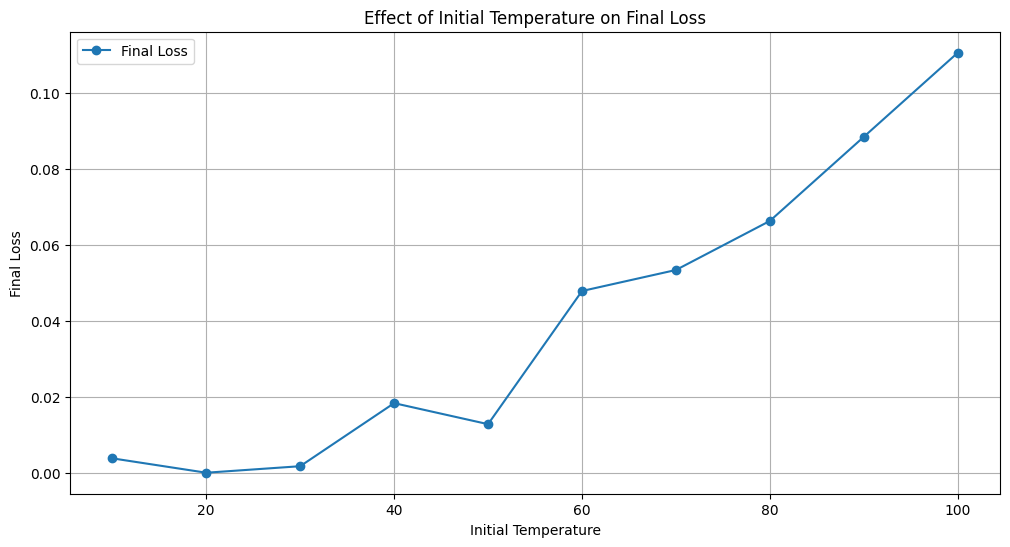

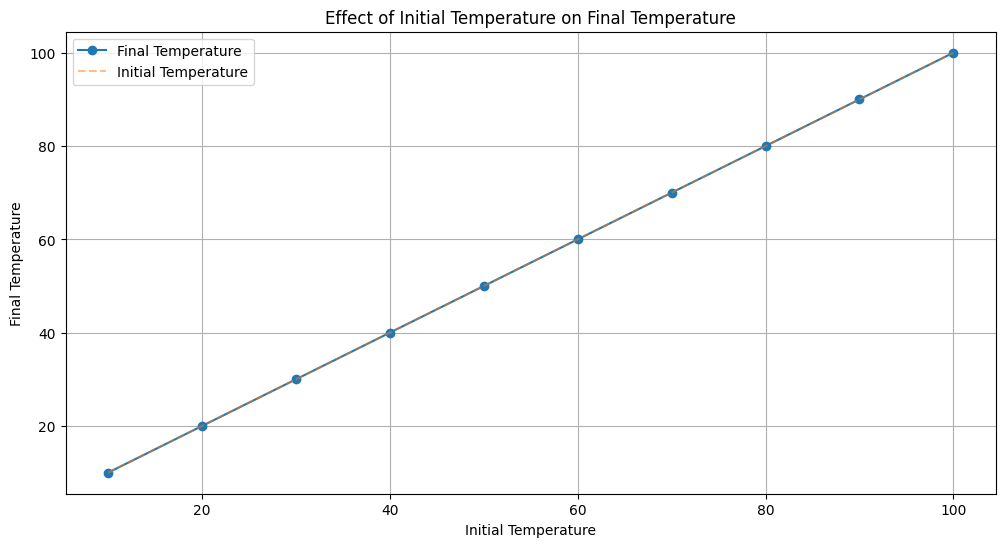

In [17]:
torch.manual_seed(50)

n_classes = 100
dim = 10
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'

initial_relative_bias = 1.0
bias_is_trainable = True
temperature_is_trainable = False
# Test a range of temperatures
temperatures = np.linspace(10, 100, 10)  # 20 evenly spaced temperatures between 10 and 50
final_losses = []
final_temps = []

print(f"Using device: {device_str}")
print(f"Running experiments with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")

for temp in temperatures:
    print(f"\nTesting temperature: {temp:.2f}")
    
    experiment = SigLIPExperiment(
        n_classes=n_classes,
        dim=dim,
        n_epochs=n_epochs,
        device=device_str
    )

    U_final, V_final, criterion_final, losses_history = experiment.train(
        relative_bias=initial_relative_bias,
        temperature=temp,
        trainable_temp=temperature_is_trainable,
        trainable_bias=bias_is_trainable
    )
    
    final_loss = losses_history[-1]
    final_temp = criterion_final.get_temperature()
    
    final_losses.append(final_loss)
    final_temps.append(final_temp.detach().item())  # Detach and convert to Python scalar
    
    print(f"Final Loss: {final_loss:.4f}")
    print(f"Final Temperature: {final_temp:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(temperatures, final_losses, 'o-', label='Final Loss')
plt.xlabel('Initial Temperature')
plt.ylabel('Final Loss')
plt.title('Effect of Initial Temperature on Final Loss')
plt.grid(True)
plt.legend()
plt.show()

# Plot final temperatures
plt.figure(figsize=(12, 6))
plt.plot(temperatures, final_temps, 'o-', label='Final Temperature')
plt.plot(temperatures, temperatures, '--', label='Initial Temperature', alpha=0.5)
plt.xlabel('Initial Temperature')
plt.ylabel('Final Temperature')
plt.title('Effect of Initial Temperature on Final Temperature')
plt.grid(True)
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

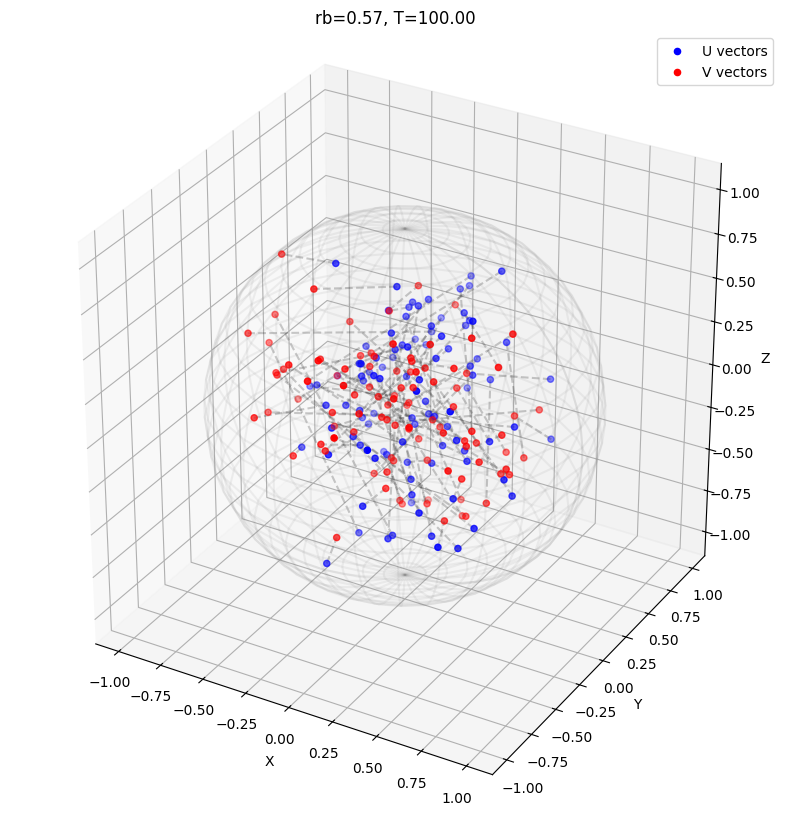

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
experiment.plot_vectors(
        U_final,
        V_final,
        criterion_final,
        ax=ax
    )
ax.legend()
plt.show